# Cross validation and model selection

In [1]:
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston, load_digits
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import average_precision_score, classification_report, precision_recall_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier

## Threefold split and parameter search
The simplest way to adjust parameters is to split the data into three parts: a training, a validation and a test set.
For each parameter setting, we fit a model on the training set, and evaluate it on the evaluation set.
We select the "best" parameter setting (or model) based on the validation set. We then rebuild a model using training and
validation data with this parameter setting, and evaluate it on the test set. The test set performance serves as an estimate of the generalization performance.

### Task 1
Load the boston housing data. Split the data into three parts, for example by calling ``train_test_split`` twice.
As yesterday, scale the data and create polynomial features.
Search the best setting for the regularization parameter alpha using the strategy described above.


In [2]:
boston = load_boston()

In [3]:
alphas = np.logspace(-3, 3, 7)
np.set_printoptions(suppress=True)
print(alphas)

[   0.001    0.01     0.1      1.      10.     100.    1000.   ]


In [4]:
X_trainval, X_test, y_trainval, y_test = train_test_split(boston.data, boston.target, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=0)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_trainval_scaled = scaler.transform(X_trainval)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

poly = PolynomialFeatures()
poly.fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_trainval_poly = poly.transform(X_trainval_scaled)
X_test_poly = poly.transform(X_test_scaled)
X_val_poly = poly.transform(X_val_scaled)

print("Performing parameter search...")
scores = []
print("{0:>12s} {1:>12s}".format("alpha","score"))
for a in alphas:
    ridge = Ridge(a)
    # Fit on training section
    ridge.fit(X_train_poly, y_train)
    # Evaluate on validation set
    score = ridge.score(X_val_poly, y_val)
    scores.append(score)
    print("{0:12.6f} {1:12.6f}".format(a,score))
    
print("Maximum score = {:12.6f}".format(scores[np.argmax(scores)]))
myalpha = alphas[np.argmax(scores)]
print("Chosen alpha  = {:12.6f}".format(myalpha))

print("Performing fit on entire training set...")
ridge = Ridge(myalpha)
ridge.fit(X_trainval_poly, y_trainval)
print("Peforming test...")
score = ridge.score(X_test_poly, y_test)
print("Score = {:12.6f}".format(score))

Performing parameter search...
       alpha        score
    0.001000    -0.237938
    0.010000    -0.264484
    0.100000    -0.261388
    1.000000    -0.093833
   10.000000     0.532292
  100.000000     0.881182
 1000.000000     0.467792
Maximum score =     0.881182
Chosen alpha  =   100.000000
Performing fit on entire training set...
Peforming test...
Score =     0.760342


## Cross validation
To get a better understanding of cross-validation, we'll implement it from scratch.
Our goal is to estimate the performance of a single model, let's say ``Ridge(alpha=1)`` on the original Boston housing dataset.

### Task 2
Complete the code below to fit a model for each of the folds of 5-fold cross-validation and compute the hold-out $R^2$ using the ``score method``.

In [5]:
# we make it divisible by n_folds to make the code simpler
X = boston.data[:505]  
y = boston.target[:505]
scores = []
n_folds = 5
n_samples = len(X)
fold_size = n_samples / n_folds
alpha = 1.0

for fold in range(n_folds):
    
    holdout_mask = np.zeros(y.shape, dtype=np.bool)
    
    # assign True to the samples that are supposed to be held out in this fold
    b = int((fold)*fold_size)
    e = int((fold+1)*fold_size)
    print("Hold out the following range: {0}-{1}".format(b,e))
    
    holdout_mask[b:e] = True
    
    # training data is inverse of hold out data
    training_mask = ~holdout_mask
    
    # assign training and hold-out portions
    X_train = X[training_mask]
    y_train = y[training_mask]
    X_test = X[holdout_mask]
    y_test = y[holdout_mask]

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    poly = PolynomialFeatures()
    poly.fit(X_train_scaled)
    X_train_poly = poly.transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)

    ridge = Ridge(alpha)
    ridge.fit(X_train_poly, y_train)
    print("Train score = {:.3f}".format(ridge.score(X_train_poly, y_train)))

    # compute scores
    score = ridge.score(X_test_poly, y_test)
    print("Test score = {:.3f}".format(score))
    print()
    scores.append(score)

Hold out the following range: 0-101
Train score = 0.941
Test score = 0.388

Hold out the following range: 101-202
Train score = 0.933
Test score = 0.474

Hold out the following range: 202-303
Train score = 0.909
Test score = 0.808

Hold out the following range: 303-404
Train score = 0.953
Test score = 0.325

Hold out the following range: 404-505
Train score = 0.948
Test score = -9.541



### Task 3
Compare the result of your implementation with the result of the ``cross_val_score`` method in scikit-learn.

In [6]:
X_train = X
y_train = y

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

poly = PolynomialFeatures()
poly.fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)

ridge = Ridge(1.0)
ridge.fit(X_train, y_train)
scores_sklearn = cross_val_score(ridge,X_train_poly,y_train,cv=5)

# compare scores_sklearn with scores
print("Scores from above:")
print(scores)
print("sklearn scores:")
print(scores_sklearn)

Scores from above:
[0.3877237401834823, 0.4735324930397263, 0.8081769972633247, 0.3251428363729584, -9.541384554586015]
sklearn scores:
[ 0.38442337  0.49846439  0.81979894  0.33522276 -4.18343582]


## Parameter selection with cross-validation
### Task 4
Implement the same search over the parameter ``alpha`` in ``Ridge`` that you did in Task 1, but instead of splitting the data three times use cross-validation.
In more detail:
- Split the Boston housing data (with polynomial features) into two parts, training and testing
- Loop over different values of alpha
- for each value of alpha, call ``cross_val_score`` on the training set, and compute the mean cross-validated accuracy.
- Select the parameter with the best mean crossvalidation accuracy, and build a model on all of the training data
- evaluate the model on the test data.

In [7]:
alphas = np.logspace(-3, 3, 7)
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

poly = PolynomialFeatures()
poly.fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

print("Performing parameter search...")
scores = []
for a in alphas:
    print("alpha: {0}".format(a))
    ridge = Ridge(a)
    ridge.fit(X_train_poly, y_train)
    cvscore = cross_val_score(ridge, X_train_poly, y_train,cv=5)
    print("Cross validated scores:")
    print(cvscore)
    score = np.mean(cvscore)
    scores.append(score)
    print("Mean cv score: {0:12.6f}\n".format(score))
    
print("best mean cross-validation score: {:.3f}".format(scores[np.argmax(scores)]))
myalpha = alphas[np.argmax(scores)]
print("best alpha  = {:.3f}".format(myalpha))

print("Performing fit on entire training set...")
ridge = Ridge(myalpha)
ridge.fit(X_train_poly, y_train)
print("Peforming test...")
score = ridge.score(X_test_poly, y_test)
print("Test score: {:.3f}".format(score))

Performing parameter search...
alpha: 0.001
Cross validated scores:
[0.81714387 0.64481679 0.51853991 0.81263918 0.90191213]
Mean cv score:     0.739010

alpha: 0.01
Cross validated scores:
[0.82075643 0.6404016  0.51408501 0.8141983  0.90094669]
Mean cv score:     0.738078

alpha: 0.1
Cross validated scores:
[0.82160875 0.6455792  0.52251992 0.82841563 0.91672881]
Mean cv score:     0.746970

alpha: 1.0
Cross validated scores:
[0.83653516 0.63123879 0.66612146 0.86625657 0.91350864]
Mean cv score:     0.782732

alpha: 10.0
Cross validated scores:
[0.86810114 0.61482753 0.87510782 0.87283602 0.90982092]
Mean cv score:     0.828139

alpha: 100.0
Cross validated scores:
[0.87295329 0.62108921 0.8225895  0.83703363 0.85123861]
Mean cv score:     0.800981

alpha: 1000.0
Cross validated scores:
[0.70925182 0.57111513 0.55666235 0.67339624 0.66144325]
Mean cv score:     0.634374

best mean cross-validation score: 0.828
best alpha  = 10.000
Performing fit on entire training set...
Peforming t

# GridSearchCV
Because searching for the parameters of a model is such a common task, scikit-learn provides ``GridSearchCV`` which implements the procedure from Task 4 (with some bells an whistles).
To use ``GridSearchCV`` we simply have to define a parameter grid to search as a dictionary, with the key the name of the parameter, and the values the parameters we like to try. The ``GridSearchCV`` class has the same interface as the classification and regression models, and we can call ``fit`` to perform the grid-search with cross-validation. It even refits the model using the best parameters! We can then use ``predict`` or ``score`` to use the model with the best parameters, retrained on the whole training data.

### Task 5
Do the same search from Task 4 (and Task 1) again, this time using ``GridSearchCV`` (from the ``sklearn.model_selection`` module).

In [8]:
alphas = np.logspace(-3, 3, 7)
param_grid = {'alpha':  alphas}
grid = GridSearchCV(Ridge(), param_grid=param_grid, cv=10, return_train_score=True)
grid.fit(X_train_poly, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.3f}".format(grid.score(X_test_poly, y_test)))

best mean cross-validation score: 0.825
best parameters: {'alpha': 10.0}
test-set score: 0.767


The ``GridSearchCV`` object stored a lot of useful information from the grid-search in the ``cv_results_`` attribute.
The easiest way to access it is to convert it to a pandas datafram:

In [9]:
results = pd.DataFrame(grid.cv_results_)

In [10]:
results.columns

Index(['mean_fit_time', 'mean_score_time', 'mean_test_score',
       'mean_train_score', 'param_alpha', 'params', 'rank_test_score',
       'split0_test_score', 'split0_train_score', 'split1_test_score',
       'split1_train_score', 'split2_test_score', 'split2_train_score',
       'split3_test_score', 'split3_train_score', 'split4_test_score',
       'split4_train_score', 'split5_test_score', 'split5_train_score',
       'split6_test_score', 'split6_train_score', 'split7_test_score',
       'split7_train_score', 'split8_test_score', 'split8_train_score',
       'split9_test_score', 'split9_train_score', 'std_fit_time',
       'std_score_time', 'std_test_score', 'std_train_score'],
      dtype='object')

In [11]:
results.params

0     {'alpha': 0.001}
1      {'alpha': 0.01}
2       {'alpha': 0.1}
3       {'alpha': 1.0}
4      {'alpha': 10.0}
5     {'alpha': 100.0}
6    {'alpha': 1000.0}
Name: params, dtype: object

We can even plot the cross-validation accuracies and their associated uncertainties:

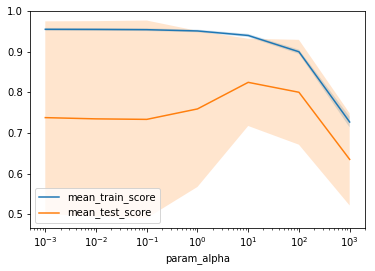

In [12]:
results.plot('param_alpha', 'mean_train_score')
results.plot('param_alpha', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_alpha.astype(np.float),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_alpha.astype(np.float),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.xscale('log')
plt.legend()
plt.show()

### Task 6
Select the best value of ``n_neighbors`` for using ``KNeighborsClassifier`` on the ``digits`` dataset.

In [13]:
digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, random_state=0)
param_grid = {'n_neighbors':  range(1,10)}
grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=10, return_train_score=True)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.3f}".format(grid.score(X_test, y_test)))

best mean cross-validation score: 0.987
best parameters: {'n_neighbors': 1}
test-set score: 0.991


In [14]:
results = pd.DataFrame(grid.cv_results_)

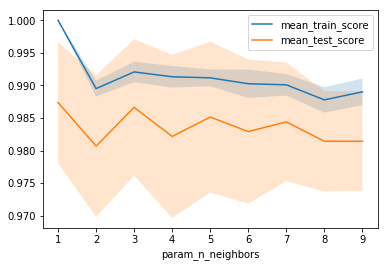

In [15]:
results.plot('param_n_neighbors', 'mean_train_score')
results.plot('param_n_neighbors', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_n_neighbors.astype(np.int),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_n_neighbors.astype(np.int),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()
plt.show()

## Evaluation Metrics and scoring

In this section, we'll look at different evaluation metrics in scikit-learn and how to use them.
There's two main ways to use metrics:
- As functions in the ``sklearn.metrics`` module, such as ``accuracy_score`` and ``roc_auc``. These take the true labels and the predictions as arguments.
- By specifying a metrics in ``cross_val_score``, ``GridSearchCV`` or another evaluation method using the ``scoring`` keyword, i.e. ``cross_val_score(..., scoring='roc_auc')``.

### Metrics for binary classification
As we mentioned, accuracy is not a great metric in imbalanced classification problems.
We'll look at some alternatives.

### Task 7
Create an imbalanced classification problem from the digits dataset by classifying the digit 4 against all other digits. In other words, train and test a model that can decide if an image represents the number 4 or is not the number 4.
Split the data into training and test set.

In [16]:
digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, random_state=0)
for index, item in enumerate(y_train):
    if item == 4:
        y_train[index] = True
    else:
        y_train[index] = False
for index, item in enumerate(y_test):
    if item == 4:
        y_test[index] = True
    else:
        y_test[index] = False

Now train a ``LogisticRegression`` model, a ``DummyClassifier(strategy='most_frequent')`` and a ``DecisionTreeClassifier(max_depth=2)``, and compare their test-set accuracy:

In [17]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
print("lr score: {:.3f}".format(lr.score(X_test,y_test)))

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train,y_train)
print("dummy score: {:.3f}".format(dummy.score(X_test,y_test)))

tree = DecisionTreeClassifier(max_depth=2)
tree.fit(X_train,y_train)
print("tree score: {:.3f}".format(tree.score(X_test,y_test)))

lr score: 0.998
dummy score: 0.916
tree score: 0.956


To get a better picture, now use the ``classification_report`` function from ``sklearn.metrics``:

In [18]:
print(classification_report(y_test,lr.predict(X_test),target_names=["is not 4","is 4"]))

             precision    recall  f1-score   support

   is not 4       1.00      1.00      1.00       412
       is 4       0.97      1.00      0.99        38

avg / total       1.00      1.00      1.00       450



In [19]:
print(classification_report(y_test,dummy.predict(X_test),target_names=["is not 4","is 4"]))

             precision    recall  f1-score   support

   is not 4       0.92      1.00      0.96       412
       is 4       0.00      0.00      0.00        38

avg / total       0.84      0.92      0.88       450



/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
print(classification_report(y_test,tree.predict(X_test),target_names=["is not 4","is 4"]))

             precision    recall  f1-score   support

   is not 4       0.96      0.99      0.98       412
       is 4       0.88      0.55      0.68        38

avg / total       0.95      0.96      0.95       450



The classification report provides precision and recall for the default threshold. To look at all possible thresholds, we can plot the precision-recall curve:

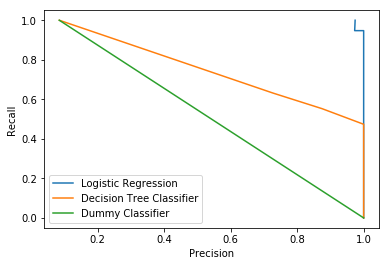

In [21]:
positive_probs_lr = lr.predict_proba(X_test)[:, 1]
positive_probs_tree = tree.predict_proba(X_test)[:, 1]
positive_probs_dummy = dummy.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, positive_probs_lr)
plt.plot(precision,recall,label="Logistic Regression")
precision, recall, thresholds = precision_recall_curve(y_test, positive_probs_tree)
plt.plot(precision,recall,label="Decision Tree Classifier")
precision, recall, thresholds = precision_recall_curve(y_test, positive_probs_dummy)
plt.plot(precision,recall,label="Dummy Classifier")
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend()
plt.show()

We can look at a summary by computing the average precision (``average_precision_score``):

In [22]:
average_precision_score(y_test,positive_probs_lr)

0.9986327153917179

In [23]:
average_precision_score(y_test,positive_probs_dummy)

0.08444444444444445

In [24]:
average_precision_score(y_test,positive_probs_tree)

0.6312905369484316

Finally, to use something like ``average_precision_score`` in cross-validation, we can simply specify the ``scoring`` argument of ``cross_val_score``. Use ``cross_val_score`` to compute the 5 fold cross-validated average precision of ``LogisticRegression`` and ``DecisionTreeClassifier(max_depth=2)``.

In [25]:
cross_val_score(LogisticRegression(),X_train,y_train,cv=5,scoring="average_precision")

array([1.        , 1.        , 0.99766151, 1.        , 0.99761905])

In [26]:
cross_val_score(DecisionTreeClassifier(max_depth=2),X_train,y_train,cv=5,scoring="average_precision")

array([0.62631135, 0.4017983 , 0.64186216, 0.66736061, 0.62242783])

In [27]:
cross_val_score(DummyClassifier(),X_train,y_train,cv=5,scoring="average_precision")

array([0.10508301, 0.1165806 , 0.10740741, 0.10085596, 0.10202178])